# Gradient Tracking

![image info](./imgs/gradient_tracking.png)

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

seed = 42
np.random.seed(seed)

In [2]:
def show_graph_and_adj_matrix(graph, adj_matrix=None):
    fig, axs = plt.subplots(figsize=(6,3), nrows=1, ncols=2)
    nx.draw(graph, with_labels=True, ax=axs[0])

    if adj_matrix is None:
        adj_matrix = nx.adjacency_matrix(graph).toarray()
    
    cax = axs[1].matshow(adj_matrix, cmap='plasma')# , vmin=0, vmax=1)
    fig.colorbar(cax)
    plt.show()

In [3]:
def create_graph_birkhoff_von_neumann(NN, num_vertices):
    I_n = np.eye(NN)
    
    # key=hash; value=np.ndarray
    vertices = {}
    
    # Number of ways to choose k items from n items without repetition and with order.
    max = math.perm(NN, NN)
    print(f"Number of possibles vertices: {math.perm(NN, NN)}") # math.factorial(NN)
    assert num_vertices <= max, "Vertices won't be unique"

    # Ensure the presence of the Identity Matrix, self-loops
    vertices[hash(I_n.tobytes())] = I_n

    while(len(vertices) < num_vertices):
        vertix = np.random.permutation(I_n)
        vertix_hash = hash(vertix.tobytes())
        
        if vertix_hash not in vertices:
            vertices[vertix_hash] = vertix
    
    # k=class_weights, the len(k) is the number of extracted numbers
    class_weights = np.ones((num_vertices)) # equally distributed classes

    convex_coefficients = np.random.dirichlet(alpha=class_weights, size=1).squeeze()
    # print(f"convex_coefficients: {convex_coefficients}")

    doubly_stochastic_matrix = np.zeros((NN, NN))
    vertices = list(vertices.values())
    # print(f"vertices: {vertices}")
    
    for i in range(num_vertices):
        doubly_stochastic_matrix += vertices[i] * convex_coefficients[i]

    # Ensure symmetry i.e. undirected graph
    doubly_stochastic_matrix = (doubly_stochastic_matrix + doubly_stochastic_matrix.T) / 2

    # print(doubly_stochastic_matrix)
    # print(np.sum(doubly_stochastic_matrix, axis=0))
    # print(np.sum(doubly_stochastic_matrix, axis=1))

    paths_up_to_N = np.linalg.matrix_power(doubly_stochastic_matrix + np.eye(NN), NN)

    # if is full, then in strongly connected
    if np.all(paths_up_to_N > 0):
        print("The graph is strongly connected")
    else: 
        print("The graph is NOT strongly connected!")

    graph = nx.from_numpy_array(doubly_stochastic_matrix)

    return graph, doubly_stochastic_matrix

In [4]:
def create_graph_iteratively(NN, p_er):
    ONES = np.ones((NN, NN))
    while 1:
        G = nx.erdos_renyi_graph(NN, p_er)
        Adj = nx.adjacency_matrix(G).toarray()
        test = np.linalg.matrix_power(Adj + np.eye(NN), NN)

        # if is full, then in strongly connected
        if np.all(test > 0):
            break

    A = Adj + np.eye(NN)

    while any(abs(np.sum(A, axis=1) - 1) > 1e-10):
        A = A / (A @ ONES)
        
        A = A / (ONES.T @ A) # removing this part, I only get row-stochastcisty
        # they converge, but not at the minimum of the sum of the cost functions
        # but to a weighted avg of the sum

        A = np.abs(A)

    return Adj, A


cost_fcn = $\frac{1}{2} Q z^{2} + rz$ <br>
gradient = $Qz + r$

In [5]:
def cost_fcn(zz, QQ, rr):
    val = 0.5 * QQ * (zz**2) + rr * zz
    grad = QQ * zz + rr
    return val, grad

In [6]:
NN = 10
Q = []
r = []
for i in range(NN):
    Q.append(10 * np.random.uniform())
    r.append(10 * np.random.normal())

# -------------------
# |   CENTRALIZED   |
# -------------------
# I have the sum of all the costs functions ell_i.
Qcentr = sum(Q)
rcentr = sum(r)
z_opt = -rcentr / Qcentr
cost_opt, _ = cost_fcn(z_opt, Qcentr, rcentr)
print(f"cost_opt: {cost_opt}")

cost_opt: -19.269116156634844


In [7]:
# -------------------------------------
# |   DISTRIBUTED GRADIENT TRACKING   |
# -------------------------------------
max_iter = 200
cost = np.zeros((max_iter))

# two states
z = np.zeros((max_iter, NN))
s = np.zeros((max_iter, NN))

# init s
for i in range(NN):
    _, s[0, i] = cost_fcn(z[0,i], Q[i], r[i])

![gradient_tracking_assumptions](./imgs/gradient_tracking_assumptions.jpg)

Number of possibles vertices: 3628800
The graph is strongly connected


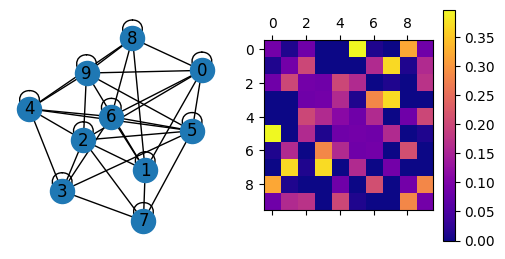

In [8]:
graph, weighted_adj = create_graph_birkhoff_von_neumann(NN, num_vertices=5)
adj_matrix = nx.adjacency_matrix(graph).toarray()
show_graph_and_adj_matrix(graph, weighted_adj)

In [9]:
alpha = 0.01

for k in range(max_iter - 1):
    for i in range(NN): # for each agent

        v_k_plus_1 = weighted_adj[i] @ z[k].T # mix with the neighbours
        
        z[k+1, i] = v_k_plus_1 - alpha * s[k, i] # step using "my"(*) gradient
        
        mixing = weighted_adj[i] @ s[k].T
        cost_ell_i_old, grad_ell_i_old = cost_fcn(z[k, i], Q[i], r[i])
        cost_ell_i_new, grad_ell_i_new = cost_fcn(z[k+1, i], Q[i], r[i])
        local_innovation = grad_ell_i_new - grad_ell_i_old
        s[k+1, i] = mixing + local_innovation        

        cost[k] += cost_ell_i_old # the sum of the costs decreases


![gradient_tracking_convergence](./imgs/gradient_tracking_convergence.jpg)

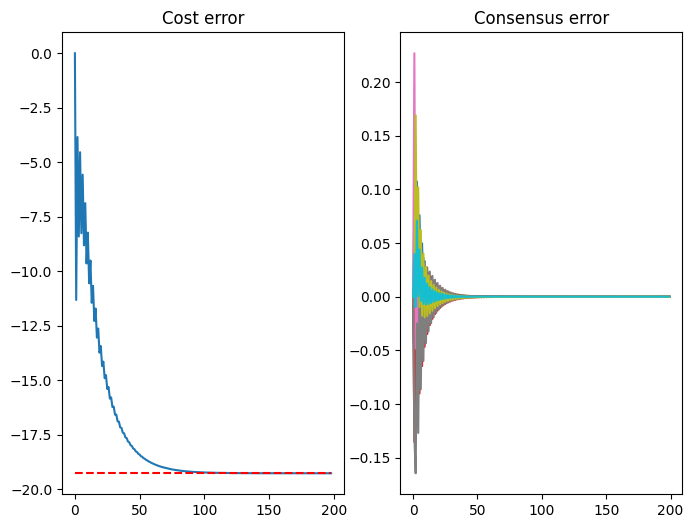

In [10]:
# graph config: [1]
fig, axes = plt.subplots(figsize=(8, 6), nrows=1, ncols=2)

ax = axes[0]
# optimal cost error - one line! we are minimizing the sum not each l_i
ax.set_title("Cost error")
ax.plot(np.arange(max_iter - 1), cost[:-1])
ax.plot(np.arange(max_iter - 1), cost_opt * np.ones((max_iter - 1)), "r--")

ax = axes[1]
z_avg = np.mean(z, axis=1)
ax.set_title("Consensus error")
for i in range(NN):
    # distance for each agent from the average of that iteration
    ax.plot(np.arange(max_iter), z[:, i] - z_avg)
    
plt.show()

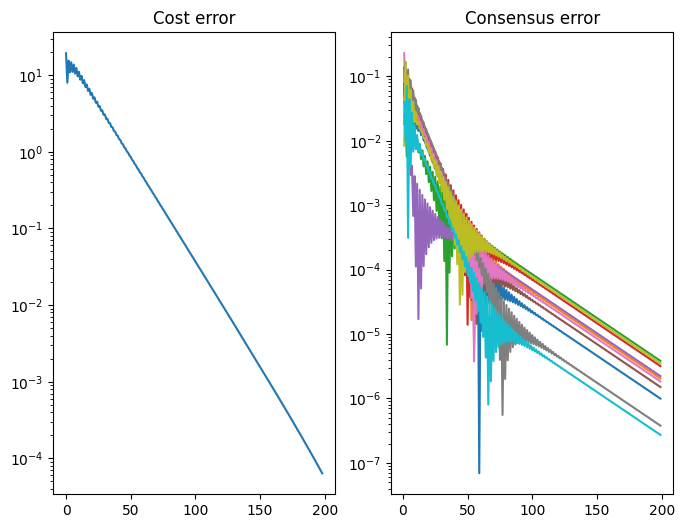

In [11]:
# graph config: [2]
# we can appreciate the LINEAR rate of convergence!
fig, axes = plt.subplots(figsize=(8, 6), nrows=1, ncols=2)

ax = axes[0]
ax.set_title("Cost error")
# optimal cost error - one line! we are minimizing the sum not each l_i
ax.semilogy(np.arange(max_iter - 1), np.abs(cost[:-1] - cost_opt))

ax = axes[1]
z_avg = np.mean(z, axis=1)
ax.set_title("Consensus error")
for i in range(NN):
    ax.semilogy(np.arange(1, max_iter), np.abs(z[1:, i] - z_avg[1:])) # NOTE: skipping k=0
    
plt.show()